In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Loading image data

In [2]:
# import pickle 128 x 128 image file
import bz2, pickle

with bz2.BZ2File('/content/drive/My Drive/Colab Notebooks/test_label_128.pbz2','r') as f:
    test_label = pickle.load(f)
with bz2.BZ2File('/content/drive/My Drive/Colab Notebooks/train_label_128.pbz2','r') as f:
    train_label = pickle.load(f)
with bz2.BZ2File('/content/drive/My Drive/Colab Notebooks/test_data_128.pbz2','r') as f:
    test_data = pickle.load(f)
with bz2.BZ2File('/content/drive/My Drive/Colab Notebooks/train_data_1_128.pbz2','r') as f:
    train_data1 = pickle.load(f)
with bz2.BZ2File('/content/drive/My Drive/Colab Notebooks/train_data_2_128.pbz2','r') as f:
    train_data2 = pickle.load(f)

print(test_label.shape)
print(test_data.shape)
print(train_label.shape)
print(train_data1.shape)
print(train_data2.shape)

(202, 14)
(202, 128, 128, 1)
(191027, 14)
(30000, 128, 128, 1)
(30000, 128, 128, 1)


In [3]:
import numpy as np

train_data = np.concatenate((train_data1, train_data2), axis = 0)
train_data1 = np.array([]); train_data2 = np.array([])
print(train_data.shape)

(60000, 128, 128, 1)


## Creating VGG-16 model

In [4]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.applications.densenet import *
from keras.applications.vgg16 import *
from keras.optimizers import *
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.models import Model, load_model
from keras.activations import *
import keras.backend as K, keras, numpy as np, cv2, tensorflow as tf, warnings
warnings.filterwarnings('ignore')

# Create a VGG-16 model 
base_model = VGG16(weights=None,include_top=False, input_shape=(128,128,1))
y = Flatten()(base_model.output)
y = Dense(1024, activation = 'relu')(y)
y = Dropout(0.5)(y)
predictions = Dense(14, activation='sigmoid')(y)
new_model = Model(input = base_model.input, output = predictions)

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Model architecture/layers

In [5]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

## Train & Test VGG-16 model

In [0]:
new_model.compile(optimizer=Adam(lr=0.0003), loss='binary_crossentropy', metrics=['accuracy'])
new_model.fit(train_data[:30000,], train_label[:30000,], validation_data = (train_data[30000:35000], train_label[30000:35000,]),epochs=15, batch_size=64)
test_loss, test_accu = new_model.evaluate(train_data[55000:60000,], train_label[55000:60000,])
print('Test Accuracy =', test_accu*100, '%')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 30000 samples, validate on 5000 samples
Epoch 1/15





30000/30000 [==============================] - 96s 3ms/step - loss: 0.3722 - acc: 0.8326 - val_loss: 0.3634 - val_acc: 0.8326
Epoch 2/15
30000/30000 [==============================] - 79s 3ms/step - loss: 0.3620 - acc: 0.8351 - val_loss: 0.3612 - val_acc: 0.8375
Epoch 3/15
30000/30000 [==============================] - 79s 3ms/step - loss: 0.3611 - acc: 0.8357 - val_loss: 0.3614 - val_acc: 0.8326
Epoch 4/15
30000/30000 [==============================] - 79s 3ms/step - loss: 0.3607 - acc: 0.8361 - val_loss: 0.3611 - val_acc: 0.8375
Epoch 5/15
30000/30000 [==============================] - 79s 3ms/step - loss: 0.3602 - acc: 0.8366 - val_loss: 0.3543 - val_acc: 0.8475
Epoch 6/15
30000/30000 [==============================] - 79s 3ms/step - loss: 0.3411 - acc: 0.8522 - val_loss: 0.3315 - val_acc: 0.8584
Epoch 7/15
30000/30000 [=

## Test image on which heatmap will be generated

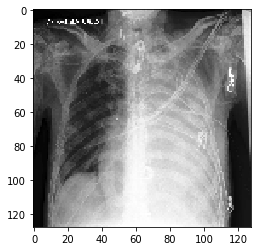

In [38]:
x = train_data[np.newaxis,37000,] 
import matplotlib.pyplot as plt
plt.imshow(x.reshape(128,128), cmap = 'gray')

## Implementing Grad-CAM on top of the VGG-16 model to generate heatmap

[10 13]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


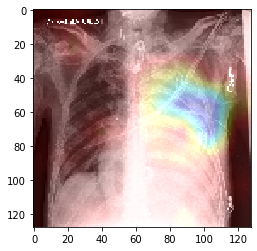

In [40]:
# Heatmap using Grad-CAM 
from skimage.color import *
import matplotlib.pyplot as plt

preds = new_model.predict(x)
print(np.where(preds[0]>0.5)[0])
# Need to find which classes are predicted and use those class indices to find heatmap for each class
class_idx = np.where(preds[0]>0.5)[0][0]
class_output = new_model.output[:, class_idx]
last_conv_layer = new_model.get_layer("block5_conv3")
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([new_model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
img = x.reshape(128,128)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
color_img = gray2rgb(img) # convert grayscale X-Ray image to color image coz heatmap is color image
superimposed_img = cv2.addWeighted(color_img, 0.999, heatmap, 0.001, 0, dtype = cv2.CV_32F)
plt.imshow(superimposed_img)

In [39]:
preds = new_model.predict(x)
print(np.where(preds[0]>0.5)[0])
print(np.where(train_label[59300]==1)[0])

[10 13]
[ 6 10 13]


In [41]:
print(preds)
print(np.where(preds[0]>0.5)[0])

[[4.2438507e-05 4.2316914e-02 5.2628398e-02 3.0296075e-01 9.3236864e-03
  3.3489615e-02 1.5766636e-01 7.1269274e-04 4.8098764e-01 1.4608800e-02
  9.5925486e-01 6.3776970e-05 2.1260600e-04 8.0731028e-01]]
[10 13]


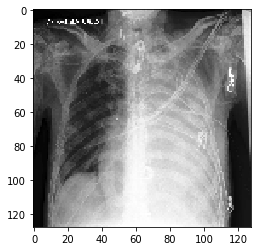

In [42]:
import matplotlib.pyplot as plt
plt.imshow(img,cmap='gray')

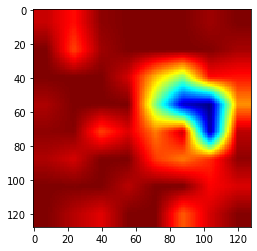

In [43]:
plt.imshow(heatmap)

## DenseNet-121 model

In [0]:
import keras, tensorflow as tf, keras.backend as K
from keras.applications.densenet import *
from keras.applications.vgg16 import *
from keras.optimizers import *
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.models import Model, load_model
from keras.activations import *
import numpy as np, pandas as pd

imdim = 128

In [0]:
base_model1 = DenseNet121(weights=None, include_top=False, input_shape=(imdim,imdim,1))
base_model1.summary()
model1 = keras.models.Sequential()
model1.add(base_model1)
model1.add(Flatten())
model1.add(Dense(1024, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(14, activation='sigmoid'))

In [0]:
model1.summary()
print(model1.output)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7031232   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              16778240  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                14350     
Total params: 23,823,822
Trainable params: 23,740,174
Non-trainable params: 83,648
_________________________________________________________________
Tensor("dense_2/Sigmoid:0", shape=(?, 14), dtype=float32)


In [0]:
model1.compile(optimizer=Adam(lr=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
model1.fit(train_data[:30000,], train_label[:30000,], validation_data = (train_data[30000:35000,], train_label[30000:35000,]), epochs=15, batch_size=64)
test_loss, test_accu = model1.evaluate(train_data[55000:60000,], train_label[55000:60000,])
print('Test Accuracy =', test_accu*100, '%')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 30000 samples, validate on 5000 samples
Epoch 1/15
30000/30000 [==============================] - 159s 5ms/step - loss: 0.3667 - acc: 0.8466 - val_loss: 0.3329 - val_acc: 0.8586
Epoch 2/15
30000/30000 [==============================] - 92s 3ms/step - loss: 0.3396 - acc: 0.8573 - val_loss: 0.3298 - val_acc: 0.8590
Epoch 3/15
30000/30000 [==============================] - 92s 3ms/step - loss: 0.3324 - acc: 0.8611 - val_loss: 0.3371 - val_acc: 0.8522
Epoch 4/15
30000/30000 [==============================] - 92s 3ms/step - loss: 0.3265 - acc: 0.8634 - val_loss: 0.3272 - val_acc: 0.8562
Epoch 5/15
30000/30000 [==============================] - 92s 3ms/step - loss: 0.3208 - acc: 0.8659 - val_loss: 0.3411 - val_acc: 0.8551
Epoch 6/15
30000/30000 [==============================] - 92s 3ms/step - loss: 0.3169 - acc: 0.8678 - val_loss: 0.3579 - val_acc: 0.8425
Epoch 7/15
30000/30000 [======

## VGG-16 model

In [0]:
base_model3 = VGG16(weights=None, include_top=False, input_shape=(imdim,imdim,1))
#base_model3.summary()
model3 = keras.models.Sequential()
model3.add(base_model3)
model3.add(Flatten())
model3.add(Dense(1024, activation = 'relu'))
model3.add(Dropout(0.5))
model3.add(Dense(14, activation='sigmoid'))

In [0]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14713536  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 14)                14350     
Total params: 23,117,518
Trainable params: 23,117,518
Non-trainable params: 0
_________________________________________________________________


In [0]:
model3.compile(optimizer=Adam(lr=0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model3.fit(train_data[:30000,], train_label[:30000,], validation_data = (train_data[30000:35000,], train_label[30000:35000,]), epochs=15, batch_size=64)
test_loss, test_accu = model3.evaluate(train_data[55000:60000,], train_label[55000:60000,])
print('Test Accuracy =', test_accu*100, '%')

Train on 30000 samples, validate on 5000 samples
Epoch 1/15
30000/30000 [==============================] - 95s 3ms/step - loss: 0.3705 - acc: 0.8330 - val_loss: 0.3612 - val_acc: 0.8375
Epoch 2/15
30000/30000 [==============================] - 77s 3ms/step - loss: 0.3618 - acc: 0.8357 - val_loss: 0.3584 - val_acc: 0.8420
Epoch 3/15
30000/30000 [==============================] - 77s 3ms/step - loss: 0.3437 - acc: 0.8506 - val_loss: 0.3319 - val_acc: 0.8568
Epoch 4/15
30000/30000 [==============================] - 77s 3ms/step - loss: 0.3312 - acc: 0.8573 - val_loss: 0.3298 - val_acc: 0.8584
Epoch 5/15
30000/30000 [==============================] - 77s 3ms/step - loss: 0.3264 - acc: 0.8603 - val_loss: 0.3253 - val_acc: 0.8609
Epoch 6/15
30000/30000 [==============================] - 77s 3ms/step - loss: 0.3218 - acc: 0.8626 - val_loss: 0.3211 - val_acc: 0.8628
Epoch 7/15
30000/30000 [==============================] - 76s 3ms/step - loss: 0.3178 - acc: 0.8647 - val_loss: 0.3206 - val_acc:

## Inception V3 model

In [0]:
from keras.applications.inception_v3 import *

base_model4 = InceptionV3(weights=None, include_top=False, input_shape=(imdim,imdim,1))
model4 = keras.models.Sequential()
model4.add(base_model4)
model4.add(Flatten())
model4.add(Dense(1024, activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(14, activation='sigmoid'))

In [0]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802208  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 14)                14350     
Total params: 30,206,190
Trainable params: 30,171,758
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
model4.compile(optimizer=Adam(lr=0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model4.fit(train_data[:30000,], train_label[:30000,], validation_data = (train_data[30000:35000,], train_label[30000:35000,]), epochs=15, batch_size=64)
test_loss, test_accu = model4.evaluate(train_data[55000:60000,], train_label[55000:60000,])
print('Test Accuracy =', test_accu*100, '%')

Train on 30000 samples, validate on 5000 samples
Epoch 1/15
30000/30000 [==============================] - 104s 3ms/step - loss: 0.3766 - acc: 0.8477 - val_loss: 0.4577 - val_acc: 0.8473
Epoch 2/15
30000/30000 [==============================] - 75s 2ms/step - loss: 0.3376 - acc: 0.8575 - val_loss: 0.3485 - val_acc: 0.8450
Epoch 3/15
30000/30000 [==============================] - 75s 2ms/step - loss: 0.3384 - acc: 0.8557 - val_loss: 0.3287 - val_acc: 0.8605
Epoch 4/15
30000/30000 [==============================] - 75s 2ms/step - loss: 0.3293 - acc: 0.8602 - val_loss: 0.3434 - val_acc: 0.8499
Epoch 5/15
30000/30000 [==============================] - 75s 2ms/step - loss: 0.3273 - acc: 0.8613 - val_loss: 0.3258 - val_acc: 0.8616
Epoch 6/15
30000/30000 [==============================] - 75s 2ms/step - loss: 0.3235 - acc: 0.8629 - val_loss: 0.3233 - val_acc: 0.8619
Epoch 7/15
30000/30000 [==============================] - 75s 2ms/step - loss: 0.3222 - acc: 0.8639 - val_loss: 0.4452 - val_acc

## MobileNet V2 model

In [0]:
from keras.applications.mobilenet_v2 import *

base_model5 = MobileNetV2(weights=None, include_top=False, input_shape=(imdim,imdim,1))
model5 = keras.models.Sequential()
model5.add(base_model5)
model5.add(Flatten())
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dropout(0.5))
model5.add(Dense(14, activation='sigmoid'))

In [0]:
model5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257408   
_________________________________________________________________
flatten_5 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              20972544  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 14)                14350     
Total params: 23,244,302
Trainable params: 23,210,190
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
model5.compile(optimizer=Adam(lr=0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model5.fit(train_data[:30000,], train_label[:30000,], validation_data = (train_data[30000:35000,], train_label[30000:35000,]), epochs=10, batch_size=64)
test_loss, test_accu = model5.evaluate(train_data[55000:60000,], train_label[55000:60000,])
print('Test Accuracy =', test_accu*100, '%')

Train on 30000 samples, validate on 5000 samples
Epoch 1/10
30000/30000 [==============================] - 89s 3ms/step - loss: 0.3987 - acc: 0.8359 - val_loss: 0.3771 - val_acc: 0.8354
Epoch 2/10
30000/30000 [==============================] - 61s 2ms/step - loss: 0.3592 - acc: 0.8493 - val_loss: 0.4179 - val_acc: 0.8327
Epoch 3/10
30000/30000 [==============================] - 61s 2ms/step - loss: 0.3499 - acc: 0.8536 - val_loss: 0.3975 - val_acc: 0.8328
Epoch 4/10
30000/30000 [==============================] - 61s 2ms/step - loss: 0.3453 - acc: 0.8553 - val_loss: 0.3471 - val_acc: 0.8460
Epoch 5/10
30000/30000 [==============================] - 61s 2ms/step - loss: 0.3416 - acc: 0.8567 - val_loss: 0.4162 - val_acc: 0.8382
Epoch 6/10
30000/30000 [==============================] - 61s 2ms/step - loss: 0.3389 - acc: 0.8581 - val_loss: 0.3471 - val_acc: 0.8523
Epoch 7/10
30000/30000 [==============================] - 61s 2ms/step - loss: 0.3358 - acc: 0.8584 - val_loss: 0.3541 - val_acc: